# Setup for TISSUE imputation analysis

This notebook contains code for setting up datasets for TISSUE imputation by pairing Near and Far cells, annotating stronger and weaker effector cells, and providing other metadata for testing of differential genes and signatures with TISSUE. The ouputs of the notebook will be used by TISSUE to perform imputation. It also runs a quick mis-segmentation test using endothelial cells.


**Associated manuscript figures/tables:**
- Supplementary Table 16


**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)


**Conda environment used**: `requirements/merfish.txt`


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree
import gseapy as gp
from sklearn.preprocessing import normalize

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

In [3]:
# global parameters

cutoff = {'CC/ACO': 24.887910095931538, 'CTX_L1/MEN': 25.91425280674148, 'CTX_L2/3': 24.04649324744985, 'CTX_L4/5/6': 27.243990001598508, 'STR_CP/ACB': 21.6499141249257, 'STR_LS/NDB': 20.355186196238336, 'VEN': 17.863153902391776} #-- combined-UPDATED

In [4]:
# place each brain further away on a grid

def gridify_brains (adata, label="mouse_id"):
    '''
    Places each brain on a grid so that spatial analyses can be done in parallel
    '''
    # determine scale for spacing
    scale_x = np.nanmax(adata.obsm["spatial"][:,0])-np.nanmin(adata.obsm["spatial"][:,0])
    scale_y = np.nanmax(adata.obsm["spatial"][:,1])-np.nanmin(adata.obsm["spatial"][:,1])
    
    scale_x = 2*scale_x
    scale_y = 2*scale_y
    
    # place grids
    counter = 0
    uniq_labels = np.unique(adata.obs[label])
    num_rows = round(np.sqrt(len(uniq_labels))+1)
    for i in range(num_rows):
        for j in range(num_rows):
            if counter < len(uniq_labels):
                # shift onto grid
                adata.obsm["spatial"][adata.obs[label]==uniq_labels[counter],:] += np.array([scale_x*i,scale_y*j])
            counter += 1
            
# convert to dataupload format (for easy reading by TISSUE)            
def convert_adata_to_dataupload (adata, savedir):
    '''
    Saves AnnData object into TISSUE input directory
    
    Parameters
    ----------
        adata - AnnData object to be saved with all metadata in adata.obs and spatial coordinates in adata.obsm['spatial']
        savedir [str] - path to existing directory to save the files for TISSUE loading
        
    Returns
    -------
        Saves all TISSUE input files into the specified directory for the given AnnData object
    '''
    locations = pd.DataFrame(adata.obsm['spatial'], columns=['x','y'])
    locations.to_csv(os.path.join(savedir,"Locations.txt"), sep="\t", index=False)
    
    df = pd.DataFrame(adata.X, columns=adata.var_names)
    df.to_csv(os.path.join(savedir,"Spatial_count.txt"), sep="\t", index=False)
    
    meta = pd.DataFrame(adata.obs)
    meta.to_csv(os.path.join(savedir,"Metadata.txt"))

### Compute AgeAccel

In [5]:
# X contains raw expression --> need log-norm for comparisons
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

In [7]:
# check that volume normalized
adata.X * np.array(adata.obs.volume)[:, np.newaxis]

array([[ 7.,  0.,  3., ...,  0.,  0.,  2.],
       [ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 9.,  0.,  1., ...,  0.,  0., 13.],
       ...,
       [15.,  0.,  1., ...,  1.,  0.,  0.],
       [ 5.,  0.,  1., ...,  0.,  0.,  0.],
       [25.,  0.,  1., ...,  0.,  0.,  3.]])

In [5]:
# compute age acceleration
get_age_acceleration (adata)

### Get proximity distances

In [6]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=np.unique(adata.obs.celltype),
                             sub_id="mouse_id")

### Subset by proximity relations

- For each celltype in celltypes, retrieve all Near and Far cells

In [7]:
cutoff_multiplier = 1

celltypes = ['T cell', 'NSC', 'Neuroblast']

###########################
keep_idxs = []

for celltype in celltypes: # effector cells
    
    prox_labels = np.array(["Other"]*adata.shape[0])
    
    for ct in restricted_celltype_subset: # affected cells
        
        sub_adata = adata[adata.obs["celltype"]==ct].copy()
        orig_idxs = np.arange(adata.shape[0])[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # update proximity labels
        prox_labels[orig_idxs] = near_ages 
        
        # keep far and near cells
        near_or_far_idxs = np.arange(sub_adata.shape[0])[(near_ages=="Near")|(near_ages=="Far")]
        keep_idxs = np.concatenate((keep_idxs,orig_idxs[near_or_far_idxs]))
    
    # annote adata with proximity (near/far/other)
    adata.obs[f"proximity to {celltype}"] = prox_labels

In [8]:
# add all T cells, NSCs, and Neuroblasts
key_ct_idxs = []
for celltype in celltypes:
    ct_idxs = np.where(adata.obs.celltype.values==celltype)[0]
    key_ct_idxs = np.concatenate((key_ct_idxs,ct_idxs))

# filter anndata
filtered_adata = adata[np.unique(np.concatenate((key_ct_idxs.astype(int), keep_idxs.astype(int)))),:].copy()

### Place brains apart on a spatial grid (for TISSUE)

In [11]:
gridify_brains (filtered_adata)

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


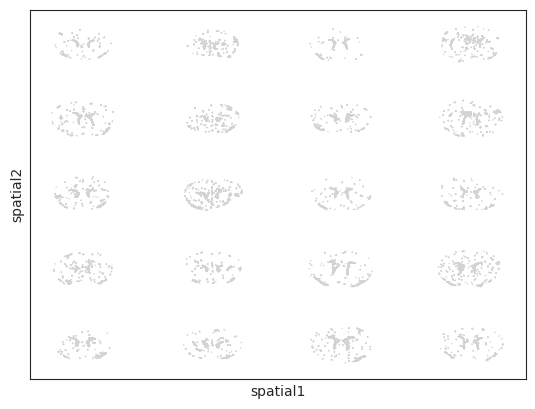

In [12]:
# visual check
sc.pl.embedding(filtered_adata,
                "spatial")

### Compute neighborhood aging

In [14]:
# build spatial graph on grid-ified data

max_cutoff = np.max([cutoff[key] for key in cutoff.keys()])
sq.gr.spatial_neighbors(filtered_adata, "spatial", coord_type='generic', radius=max_cutoff)

In [15]:
# compute neighborhood age accel

w_normalized = normalize(filtered_adata.obsp['spatial_connectivities'], norm='l1', axis=1)
nbr_ageaccel = w_normalized @ filtered_adata.obs["normalized_age_acceleration"].values
nbr_ageaccel[~filtered_adata.obs.celltype.isin(['T cell', 'NSC', 'Neuroblast'])] = np.nan

filtered_adata.obs["neighborhood_ageaccel"] = nbr_ageaccel

In [17]:
# get quartile cutoffs
nsc_cutoff = np.quantile(filtered_adata.obs["neighborhood_ageaccel"][filtered_adata.obs.celltype=="NSC"], 0.5)
neuroblast_cutoff = np.quantile(filtered_adata.obs["neighborhood_ageaccel"][filtered_adata.obs.celltype=="Neuroblast"], 0.5)
tcell_cutoff = np.quantile(filtered_adata.obs["neighborhood_ageaccel"][filtered_adata.obs.celltype=="T cell"], 0.5)

In [18]:
# binary labeling -- NSC
labels = np.array(["Others"]*filtered_adata.shape[0])
labels[(filtered_adata.obs.neighborhood_ageaccel<nsc_cutoff)&(filtered_adata.obs.celltype=="NSC")] = "Strong"
labels[(filtered_adata.obs.neighborhood_ageaccel>=nsc_cutoff)&(filtered_adata.obs.celltype=="NSC")] = "Weak"
filtered_adata.obs["NSC_neighborhood_type"] = labels

# binary labeling -- Neuroblast
labels = np.array(["Others"]*filtered_adata.shape[0])
labels[(filtered_adata.obs.neighborhood_ageaccel<neuroblast_cutoff)&(filtered_adata.obs.celltype=="Neuroblast")] = "Strong"
labels[(filtered_adata.obs.neighborhood_ageaccel>=neuroblast_cutoff)&(filtered_adata.obs.celltype=="Neuroblast")] = "Weak"
filtered_adata.obs["Neuroblast_neighborhood_type"] = labels

# binary labeling -- T cell
labels = np.array(["Others"]*filtered_adata.shape[0])
labels[(filtered_adata.obs.neighborhood_ageaccel>tcell_cutoff)&(filtered_adata.obs.celltype=="T cell")] = "Strong"
labels[(filtered_adata.obs.neighborhood_ageaccel<=tcell_cutoff)&(filtered_adata.obs.celltype=="T cell")] = "Weak"
filtered_adata.obs["T cell_neighborhood_type"] = labels

### Save anndata

In [24]:
# save resulting anndata for TISSUE imputation
filtered_adata.write_h5ad("results/for_imputation/TcellNSCNeuroblast_subset.h5ad")

### Optional: Subclassify as near strong vs near weak

In [5]:
filtered_adata = sc.read_h5ad("results/for_imputation/TcellNSCNeuroblast_subset.h5ad")

In [ ]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=np.unique(adata.obs.celltype),
                             sub_id="mouse_id")

In [14]:
# Subset into spatial coordinates
for ct in ["NSC", "T cell", "Neuroblast"]:
    
    finegrained_proximity_relations = filtered_adata.obs[f"proximity to {ct}"].values.astype(str).copy()
    
    # Define targets
    spatial_targets = filtered_adata[filtered_adata.obs["celltype"]==ct].obsm["spatial"].copy()
    spatial_all = filtered_adata[filtered_adata.obs[f"proximity to {ct}"]=="Near"].obsm["spatial"].copy()

    # Create a BallTree 
    tree = BallTree(spatial_targets, leaf_size=2)

    # Query the BallTree
    distances2, idxs = tree.query(spatial_all,  k=2)
    idxs = idxs[:,0].copy()
    
    # Annotate new relations
    strong_weak_labels = filtered_adata[filtered_adata.obs["celltype"]==ct].obs[f"{ct}_neighborhood_type"].values.copy()[idxs]
    finegrained_proximity_relations[filtered_adata.obs[f"proximity to {ct}"]=="Near"] = np.array(["Near"+swl for swl in strong_weak_labels])
    filtered_adata.obs[f"finegrained proximity to {ct}"] = finegrained_proximity_relations
    filtered_adata.obs[f"finegrained proximity to {ct}"] = filtered_adata.obs[f"finegrained proximity to {ct}"].astype('category')

In [22]:
filtered_adata.write_h5ad("results/for_imputation/TcellNSCNeuroblast_subset_finegrainedNear.h5ad")

In [29]:
filtered_adata

AnnData object with n_obs × n_vars = 26222 × 300
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'doublet_score', 'num_detected_genes', 'barcodeCount', 'mouse_id', 'slide_id', 'cohort', 'age', 'batch', 'clusters', 'celltype', 'kmeans', 'region', 'predicted_age', 'age_acceleration', 'average_predicted_age', 'normalized_age_acceleration', 'Astrocyte_nearest_distance', 'B cell_nearest_distance', 'Endothelial_nearest_distance', 'Ependymal_nearest_distance', 'Macrophage_nearest_distance', 'Microglia_nearest_distance', 'NSC_nearest_distance', 'Neuroblast_nearest_distance', 'Neuron-Excitatory_nearest_distance', 'Neuron-Inhibitory_nearest_distance', 'Neuron-MSN_nearest_distance', 'Neutrophil_nearest_distance', 'OPC_nearest_distance', 'Oligodendrocyte_nearest_distance', 'Pericyte_nearest_distance', 'T cell_nearest_distance', 'VLMC_nearest_distance', 'VSMC_nearest_distance', 'proximity to 

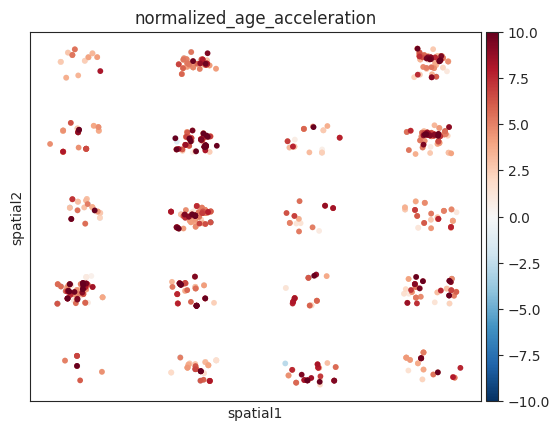

In [38]:
# visual check

sc.pl.embedding(filtered_adata[filtered_adata.obs['finegrained proximity to T cell']=="NearS"], "spatial", color="normalized_age_acceleration",
               cmap = "RdBu_r", vmin=-10, vmax=10)

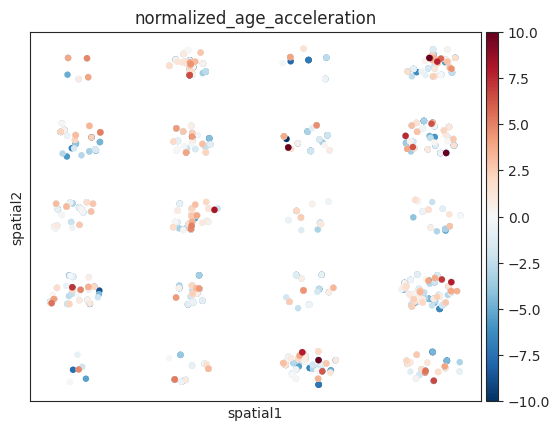

In [39]:
# visual check

sc.pl.embedding(filtered_adata[filtered_adata.obs['finegrained proximity to T cell']=="NearW"], "spatial", color="normalized_age_acceleration",
               cmap = "RdBu_r", vmin=-10, vmax=10)

## Convert into directory for TISSUE

In [5]:
filtered_adata = sc.read_h5ad("results/for_imputation/TcellNSCNeuroblast_subset.h5ad")

In [9]:
# cell types near NSC
near_nsc = filtered_adata[filtered_adata.obs['proximity to NSC']=="Near"]
df = pd.DataFrame(np.unique(near_nsc.obs.celltype, return_counts=True))

In [10]:
df.to_csv('results/for_imputation/near_celltype_breakdown_nsc.csv',
         index=None)

In [11]:
# cell types near T cells
near_tc = filtered_adata[filtered_adata.obs['proximity to T cell']=="Near"]
df = pd.DataFrame(np.unique(near_tc.obs.celltype, return_counts=True))

In [12]:
df.to_csv('results/for_imputation/near_celltype_breakdown_tcell.csv',
         index=None)

In [28]:
convert_adata_to_dataupload (filtered_adata,
                            "results/for_imputation/DataUpload/SVZ")

In [5]:
convert_adata_to_dataupload (filtered_adata,
                            "results/for_imputation/DataUpload/SVZDulken")